In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import mariadb
import sys

import os
from dotenv import load_dotenv


### Conexão com o banco de dados

In [3]:
class DBConnection:
    @staticmethod
    def getConnection():
        load_dotenv(override=True)
        try:
            conn = mariadb.connect(
                user=os.environ['DATABASE_USERNAME'],
                password=os.environ['DATABASE_PASSWORD'],
                host=os.environ['HOST_CONNECT'],
                port=int(os.environ['DATABASE_PORT']),
                database=os.environ['DATABASE_NAME']

            )
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)
            
        return conn.cursor(dictionary=True)

conn = DBConnection.getConnection()


### NPS dos produtos

In [4]:
conn.execute("""
    SELECT wp_posts.post_title, AVG(wp_commentmeta.meta_value) as nps FROM wp_posts
    INNER JOIN wp_comments ON wp_posts.ID = wp_comments.comment_post_ID
    INNER JOIN wp_commentmeta ON wp_comments.comment_ID = wp_commentmeta.comment_id
    WHERE
    wp_commentmeta.meta_key = 'rating'
    GROUP BY wp_posts.post_title
    ORDER BY nps DESC
""")

nps = pd.DataFrame(conn.fetchall())
nps

,post_title,nps
0,E-Class,4.10
1,Dakota Club,4.00
2,W201,4.00
3,Horizon,4.00
4,Diamante,4.00
...,...,...
66,S80,2.80
67,H1,2.75
68,SLK-Class,2.50
69,XJ,2.00


### Médias

In [5]:
conn.execute("""
    SELECT AVG(total_sales) FROM wp_wc_order_stats
""")

ticket_medio = pd.DataFrame(conn.fetchall())

conn.execute("""
    SELECT AVG(num_items_sold) FROM wp_wc_order_stats
""")

media_itens_carrinho = pd.DataFrame(conn.fetchall())
media_itens_carrinho, ticket_medio

(  AVG(num_items_sold)
 0              2.2466,
    AVG(total_sales)
 0     273758.872067)

### Churn

#### Churn mensal

O Churn mensal da unidade pode ser calculado da seguinte forma:

C = CP / TCMA

1. CP é a quantidade de clientes perdidos
2. TCMA é o total de clientes no mês anterior
3. C é o Churn

Vamos considerar como um cliente perdido aquele que não teve nenhuma interação com organização em 24 meses

In [6]:
from datetime import datetime, date, timedelta

# primeiro_dia_mes = datetime.today().strftime('%Y-%m') + "-01"
primeiro_dia_mes = "2022-08-01"

ano_atual = datetime.today().strftime('%Y')
dois_anos_atras = str(int(ano_atual) - 2) + "-" + datetime.today().strftime('%m-%d')

qt_novos_clientes_mes_anterior = conn.execute("""
    SELECT
        count(*) as qt
    FROM wp_users
    INNER JOIN wp_wc_customer_lookup ON wp_users.ID = wp_wc_customer_lookup.user_id
    WHERE user_registered >= %s
""", [primeiro_dia_mes])

qt_novos_clientes_mes_anterior = pd.DataFrame(conn.fetchall())

qt_clientes_perdios = conn.execute("""
    SELECT
        count(*) as qt
    FROM wp_wc_customer_lookup
    WHERE wp_wc_customer_lookup.date_last_active < %s
""", [dois_anos_atras])

qt_clientes_perdios = pd.DataFrame(conn.fetchall())

churn_mensal = qt_clientes_perdios['qt'][0] / qt_novos_clientes_mes_anterior['qt'][0] * 100
churn_mensal

7.142857142857142

### Churn bruto pode ser calculado da seguinte forma:
CB = MRR′ / MRR′′

Onde MRR’ é a receita recorrente mensal de um determinado mês, MRR” é a receita
recorrente mensal do início do mês e CB é Churn Bruto.


In [7]:
def get_mrr():
    primeiro_dia_mes = datetime.today().strftime('%Y-%m') + "-01"
    hoje = datetime.today()

    conn.execute("""
        SELECT AVG(total_sales) mean FROM wp_wc_order_stats WHERE date_created BETWEEN %s AND %s
    """, [primeiro_dia_mes, hoje.strftime('%Y-%m-%d')])

    mrr_i = pd.DataFrame(conn.fetchall())

    dias_subtracao = int(datetime.today().strftime('%d')) + 1
    td = timedelta(dias_subtracao * -1)

    ultimo_dia_mes_passado = hoje + td
    ultimo_dia_mes_passado = ultimo_dia_mes_passado.strftime('%Y-%m-%d')

    dias_mes_passado = int((hoje + td).strftime('%d')) * -1
    td_2 = timedelta(dias_mes_passado)

    primeiro_dia_mes_passado = hoje + td + td_2
    primeiro_dia_mes_passado = primeiro_dia_mes_passado.strftime('%Y-%m-%d')

    conn.execute("""
        SELECT AVG(total_sales) mean FROM wp_wc_order_stats WHERE date_created BETWEEN %s AND %s
    """, [primeiro_dia_mes_passado, ultimo_dia_mes_passado])

    mrr_ii = pd.DataFrame(conn.fetchall())

    mrr_i = mrr_i['mean'][0]
    mrr_ii = mrr_ii['mean'][0]

    return [mrr_i, mrr_ii]

def get_churn_bruto(mrr_i, mrr_ii):
    if mrr_i == None:
        return 1 * 100

    if mrr_ii == None:
        return 0 * 100

    return mrr_i / mrr_ii * 100

mrr_i, mrr_ii = get_mrr()

churn_bruto = get_churn_bruto(mrr_i, mrr_ii)
churn_bruto

100

### Churn Líquido
O Churn Líquido se da pela equação:
CL = MRR′ −UPSELLS′ / MRR′′
o MRR’ é a perda de receita recorrente mensal no mês X, o UPSELLS’, em e-commerces
é o aumento do ticket médio, em serviços de assinatura é o valor da assinatura e CL é Churn líquido

In [8]:
def get_delta_tickt_medio():
    mrr_i, mrr_ii = get_mrr()
    if mrr_i == None:
        mrr_i = 0

    if mrr_ii == None:
        mrr_ii = 0

    upsells = mrr_i - mrr_ii
    return upsells

def get_churn_liquido():
    upsell = get_delta_tickt_medio()
    mrr_i, mrr_ii = get_mrr()

    if mrr_i == None:
        mrr_i = 0

    if mrr_ii == None:
        mrr_ii = 0

    return mrr_i - upsell / mrr_ii

churn_liquido = get_churn_liquido()
churn_liquido

1.0

### CLV

CLV = ∑ (pt − ct )rt / (1 + i)r − CAC

Onde

pt = valor da compra no tempo t,

ct = quaisquer custos relacionado a compra no tempo t,

i = taxa de desconto ou custo de capital para a empresa,

T∗= expectativa do tempo de relacionamento com o cliente (Para Kepler, 24 meses),

CAC = custo de aquisição de cliente

In [25]:

hoje = datetime.today().strftime('%Y-%m-%d')
dois_anos_atras = str(int(ano_atual) - 2) + "-" + datetime.today().strftime('%m-%d')

taxa_conversao = 0.05

receita_liquida_sql = conn.execute("""
    SELECT SUM(net_total) as nt FROM `wp_wc_order_stats` WHERE date_created BETWEEN %s AND %s
""", [dois_anos_atras, hoje])

receita_liquida = pd.DataFrame(conn.fetchall())
receita_liquida = receita_liquida['nt']

clv = receita_liquida * taxa_conversao / (1 + 0.11)
clv


0    1.724888e+07
Name: nt, dtype: float64

In [24]:
media_tv_cliente = 1 / churn_mensal
kepler_ltv = receita_liquida * media_tv_cliente
kepler_ltv

0    5.360953e+07
Name: nt, dtype: float64

### Obtendo dados dos pedidos


In [10]:
relacao_pedidos = conn.execute("""
    SELECT 
        wp_wc_order_product_lookup.product_id,
        wp_wc_order_product_lookup.product_qty, 
        # wp_wc_order_product_lookup.date_created, 
        (wp_wc_order_product_lookup.product_net_revenue / wp_wc_order_product_lookup.product_qty) as unit_net_revenue,
        (wp_wc_order_product_lookup.product_gross_revenue / wp_wc_order_product_lookup.product_qty) as unit_gross_revenue,
        wp_wc_product_meta_lookup.max_price as current_price,
        wp_wc_product_meta_lookup.average_rating as nps,
        wp_wc_product_meta_lookup.rating_count
    FROM wp_wc_order_product_lookup
    INNER JOIN wp_posts ON wp_wc_order_product_lookup.product_id = wp_posts.ID
    INNER JOIN wp_wc_product_meta_lookup ON  wp_posts.ID = wp_wc_product_meta_lookup.product_id
""")

pedidos = pd.DataFrame(conn.fetchall())
pedidos

,product_id,product_qty,unit_net_revenue,unit_gross_revenue,current_price,nps,rating_count
0,19,1,25918.59,51837.180000,25918.5900,4.00,3
1,19,1,25918.59,79738.350000,25918.5900,4.00,3
2,20,1,83926.61,147965.440000,83926.6100,3.00,1
3,21,1,26334.22,79800.215000,26334.2200,3.29,7
4,21,1,26334.22,54083.805000,26334.2200,3.29,7
...,...,...,...,...,...,...,...
6002,80,1,23177.94,82017.630000,23177.9400,3.43,7
6003,81,1,80228.10,129346.126667,80228.1000,0.00,0
6004,82,1,60923.26,121846.520000,60923.2600,3.00,8
6005,83,1,31046.26,87866.098000,31046.2600,3.50,4


### Padronizando variáveis

In [31]:
from sklearn.preprocessing import StandardScaler
import random

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pedidos)
scaled_orders = pd.DataFrame(scaled_data)
scaled_orders.columns = pedidos.columns
scaled_orders['target'] = [random.randrange(0, 2, 1) for i in range(6007)]
scaled_orders

,product_id,product_qty,unit_net_revenue,unit_gross_revenue,current_price,nps,rating_count,target
0,-3.016008,-0.174792,-1.489400,-1.899575,-1.489400,2.099615,-1.647489,1
1,-3.016008,-0.174792,-1.489400,-1.149411,-1.489400,2.099615,-1.647489,1
2,-2.917088,-0.174792,0.909088,0.684976,0.909088,-1.096113,-2.084197,1
3,-2.818168,-0.174792,-1.472215,-1.147748,-1.472215,-0.169352,-0.774072,1
4,-2.818168,-0.174792,-1.472215,-1.839172,-1.472215,-0.169352,-0.774072,1
...,...,...,...,...,...,...,...,...
6002,3.018099,-0.174792,-1.602719,-1.088129,-1.602719,0.278050,-0.774072,0
6003,3.117019,-0.174792,0.756163,0.184368,0.756163,-10.683296,-2.302552,1
6004,3.215939,-0.174792,-0.042044,-0.017270,-0.042044,-1.096113,-0.555718,1
6005,3.314858,-0.174792,-1.277384,-0.930884,-1.277384,0.501751,-1.429135,1


### Corelação das variáveis 

<AxesSubplot:>

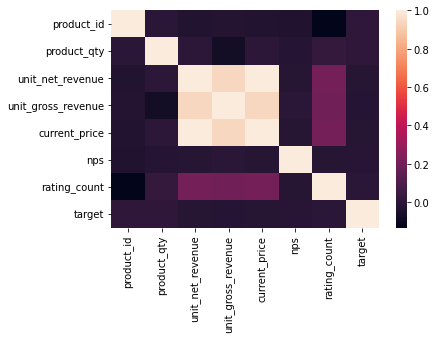

In [32]:
sns.heatmap(scaled_orders.corr())

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = scaled_orders.drop('target', axis=1).values
Y = scaled_orders['target'].values

X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size=0.25, random_state=0)

X_treino, X_teste, Y_treino, Y_teste

(array([[ 1.73214188, -0.17479182,  0.94699461, ...,  0.94699461,
          1.46046942, -1.21078068],
        [ 0.14942536, -0.17479182, -0.73553326, ..., -0.73553326,
         -0.29718087,  1.19111536],
        [ 1.83106167, -0.17479182,  0.30939472, ...,  0.30939472,
          1.04502481, -1.64748905],
        ...,
        [-0.64193291, -0.17479182,  1.19195305, ...,  1.19195305,
          0.27805013, -0.77407231],
        [-0.14733399, -0.17479182,  0.21442318, ...,  0.21442318,
         -1.09611283, -1.21078068],
        [-0.14733399, -0.17479182,  0.21442318, ...,  0.21442318,
         -1.09611283, -1.21078068]]),
 array([[ 0.05050557, -0.17479182, -1.59358987, ..., -1.59358987,
         -1.63938656, -0.9924265 ],
        [ 0.4461847 , -0.17479182, -0.54041223, ..., -0.54041223,
          0.69349475, -0.33736394],
        [ 0.4461847 , -0.17479182, -0.54041223, ..., -0.54041223,
          0.69349475, -0.33736394],
        ...,
        [ 0.54510449, -0.17479182, -1.35517137, ..., -

In [36]:
modelo = LogisticRegression()
modelo.fit(X_treino, Y_treino)

LogisticRegression()

In [37]:
score_treino = modelo.score(X_treino, Y_treino)
score_treino

0.5125416204217536

In [38]:
Y_previsto = modelo.predict(X_teste)
Y_previsto

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [39]:
score_teste = modelo.score(X_teste, Y_teste)
score_teste

0.4840213049267643

<AxesSubplot:>

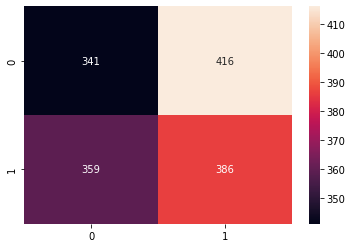

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_teste, Y_previsto)
sns.heatmap(cm,annot=True, fmt="d")

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
fpr, tpr, _ = roc_curve(Y_teste, Y_previsto)
roc_auc = auc(fpr, tpr) * 100
roc_auc

48.429157837809086

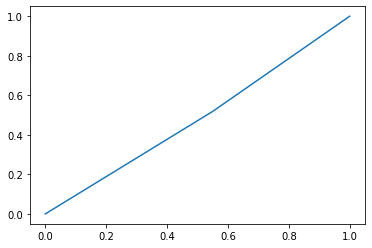

In [44]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)